%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install jiwer
%pip install evaluate --upgrade
%pip install wandb --upgrade

In [2]:
import pandas as pd
import datasets
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
from transformers import AutoProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
# import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
if 'data' not in locals():
    data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
    data = data.iloc[:10000]
    data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style'})
    data = data[['image','author','title','style']]
    data['image'] = [f'.{x}' for x in data['image']]
if 'labels_auth' not in locals():
    labels_auth = data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label
if 'labels_sty' not in locals():
    labels_sty = data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [4]:
data['author'] = data['author'].map(label2id_auth)
data['style'] = data['style'].map(label2id_sty)
print(data.columns)

Index(['image', 'author', 'title', 'style'], dtype='object')


In [4]:
dataset = datasets.Dataset.from_pandas(data).cast_column('image',datasets.Image())
print(dataset)

Dataset({
    features: ['image', 'author', 'title', 'style'],
    num_rows: 10000
})


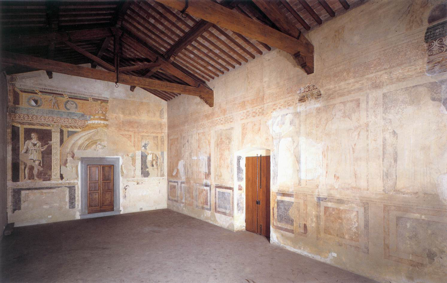

Title: View of the former loggia
Author: ANDREA DEL CASTAGNO
Technique: Photo


In [5]:
sample = dataset[423]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
# caption = sample['description']
author = id2label_auth[sample['author']]
technique = id2label_sty[sample['style']]
# print(f'Description: {caption}')
print(f'Author: {author}')
print(f'Technique: {technique}')

In [6]:

checkpoint_clas = 'google/vit-base-patch16-224-in21k'
processor_clas = AutoProcessor.from_pretrained(checkpoint_clas)

In [8]:
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor_clas.image_mean, std=processor_clas.image_std)

size = (
    processor_clas.size["shortest_edge"]
    if "shortest_edge" in processor_clas.size
    else (processor_clas.size["height"], processor_clas.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [9]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


In [10]:
model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint_clas,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint_clas,
    num_labels = len(labels_sty),
    id2label = id2label_sty,
    label2id = label2id_sty
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#Author
auth_data = dataset.remove_columns(['style','title']).rename_column('author','label')
auth_dataset = auth_data.train_test_split(test_size=0.3)
auth_dataset = auth_dataset.with_transform(transforms)

In [14]:
#Style
sty_data = dataset.remove_columns(['author','title']).rename_column('style','label')
sty_dataset = sty_data.train_test_split(test_size=0.3)
sty_dataset = sty_dataset.with_transform(transforms)

In [18]:
vit_model_auth = model_clas_auth.to(device)
vit_model_sty = model_clas_sty.to(device)

In [19]:
vit_optimizer_auth = torch.optim.AdamW(vit_model_auth.parameters(), lr=1e-5)
vit_optimizer_sty = torch.optim.AdamW(vit_model_sty.parameters(), lr=1e-5)

vit_criterion_auth = nn.CrossEntropyLoss()
vit_criterion_sty = nn.CrossEntropyLoss()

In [21]:
num_epochs_class = 50
torch.cuda.empty_cache()

In [22]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted',zero_division=0)
    recall = recall_score(labels, preds, average='weighted',zero_division=0)
    f1 = f1_score(labels, preds, average='weighted',zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
auth_training_args = TrainingArguments(
    output_dir="model_checkpoints/auth",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs_class,
    warmup_ratio=0.1,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)



auth_trainer = Trainer(
    model = vit_model_auth,
    args = auth_training_args,
    data_collator=data_collator,
    train_dataset = auth_dataset['train'],
    eval_dataset = auth_dataset['test'],
    tokenizer = processor_clas,
    compute_metrics = compute_metrics,
)

auth_trainer.train()
torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


wandb: WARNING Serializing object of type dict that is 147552 bytes
wandb: WARNING Serializing object of type dict that is 147552 bytes


  0%|          | 0/34150 [00:00<?, ?it/s]

{'loss': 8.3969, 'learning_rate': 7.32064421669107e-06, 'epoch': 0.73}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 8.193991661071777, 'eval_accuracy': 0.03241975045323664, 'eval_precision': 0.010526242543664296, 'eval_recall': 0.03241975045323664, 'eval_f1': 0.0062506595726090795, 'eval_runtime': 424.9572, 'eval_samples_per_second': 22.066, 'eval_steps_per_second': 2.76, 'epoch': 1.0}
{'loss': 8.1232, 'learning_rate': 1.464128843338214e-05, 'epoch': 1.46}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 7.793569087982178, 'eval_accuracy': 0.045856883864775516, 'eval_precision': 0.006609449031149871, 'eval_recall': 0.045856883864775516, 'eval_f1': 0.00894787631783663, 'eval_runtime': 506.0423, 'eval_samples_per_second': 18.53, 'eval_steps_per_second': 2.318, 'epoch': 2.0}
{'loss': 7.7652, 'learning_rate': 2.1961932650073208e-05, 'epoch': 2.19}
{'loss': 7.3858, 'learning_rate': 2.928257686676428e-05, 'epoch': 2.93}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 7.35518741607666, 'eval_accuracy': 0.05684120720912872, 'eval_precision': 0.011048668509479236, 'eval_recall': 0.05684120720912872, 'eval_f1': 0.011360168926617046, 'eval_runtime': 522.379, 'eval_samples_per_second': 17.951, 'eval_steps_per_second': 2.245, 'epoch': 3.0}
{'loss': 6.9938, 'learning_rate': 3.6603221083455344e-05, 'epoch': 3.66}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 6.9200825691223145, 'eval_accuracy': 0.07763677082222459, 'eval_precision': 0.018836204255908418, 'eval_recall': 0.07763677082222459, 'eval_f1': 0.021504614764434087, 'eval_runtime': 413.7215, 'eval_samples_per_second': 22.665, 'eval_steps_per_second': 2.835, 'epoch': 4.0}
{'loss': 6.6213, 'learning_rate': 4.3923865300146415e-05, 'epoch': 4.39}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 6.505573749542236, 'eval_accuracy': 0.12061426895595606, 'eval_precision': 0.04108229148581224, 'eval_recall': 0.12061426895595606, 'eval_f1': 0.05032180186668771, 'eval_runtime': 309.8864, 'eval_samples_per_second': 30.259, 'eval_steps_per_second': 3.785, 'epoch': 5.0}
{'loss': 6.294, 'learning_rate': 4.986172116479584e-05, 'epoch': 5.12}
{'loss': 5.908, 'learning_rate': 4.904831625183016e-05, 'epoch': 5.85}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 6.145905494689941, 'eval_accuracy': 0.15186093633358216, 'eval_precision': 0.05706775287527556, 'eval_recall': 0.15186093633358216, 'eval_f1': 0.07043450523202834, 'eval_runtime': 754.3702, 'eval_samples_per_second': 12.43, 'eval_steps_per_second': 1.555, 'epoch': 6.0}
{'loss': 5.6213, 'learning_rate': 4.8234911338864494e-05, 'epoch': 6.58}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 5.891831874847412, 'eval_accuracy': 0.17606910525754504, 'eval_precision': 0.0741896444502021, 'eval_recall': 0.17606910525754504, 'eval_f1': 0.08953386208348817, 'eval_runtime': 3549.9805, 'eval_samples_per_second': 2.641, 'eval_steps_per_second': 0.33, 'epoch': 7.0}
{'loss': 5.2854, 'learning_rate': 4.7421506425898814e-05, 'epoch': 7.31}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 5.6464972496032715, 'eval_accuracy': 0.19974405460168498, 'eval_precision': 0.10488282271334655, 'eval_recall': 0.19974405460168498, 'eval_f1': 0.11764522817921315, 'eval_runtime': 804.8142, 'eval_samples_per_second': 11.651, 'eval_steps_per_second': 1.457, 'epoch': 8.0}
{'loss': 5.072, 'learning_rate': 4.660810151293314e-05, 'epoch': 8.04}
{'loss': 4.8148, 'learning_rate': 4.579469659996747e-05, 'epoch': 8.78}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 5.445225238800049, 'eval_accuracy': 0.21936653513917032, 'eval_precision': 0.11729190412844283, 'eval_recall': 0.21936653513917032, 'eval_f1': 0.13382633087110088, 'eval_runtime': 801.916, 'eval_samples_per_second': 11.693, 'eval_steps_per_second': 1.463, 'epoch': 9.0}
{'loss': 4.5475, 'learning_rate': 4.498129168700179e-05, 'epoch': 9.51}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 5.262511730194092, 'eval_accuracy': 0.24304148448331023, 'eval_precision': 0.13573209667647995, 'eval_recall': 0.24304148448331023, 'eval_f1': 0.1605885862263129, 'eval_runtime': 785.2141, 'eval_samples_per_second': 11.942, 'eval_steps_per_second': 1.494, 'epoch': 10.0}
{'loss': 4.3531, 'learning_rate': 4.416788677403612e-05, 'epoch': 10.24}
{'loss': 4.1591, 'learning_rate': 4.3354481861070446e-05, 'epoch': 10.97}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 5.148559093475342, 'eval_accuracy': 0.25797163271835344, 'eval_precision': 0.149431569817608, 'eval_recall': 0.25797163271835344, 'eval_f1': 0.1770211935716681, 'eval_runtime': 430.732, 'eval_samples_per_second': 21.77, 'eval_steps_per_second': 2.723, 'epoch': 11.0}
{'loss': 3.8961, 'learning_rate': 4.254107694810477e-05, 'epoch': 11.7}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.995755672454834, 'eval_accuracy': 0.2723685613735736, 'eval_precision': 0.1675438953447644, 'eval_recall': 0.2723685613735736, 'eval_f1': 0.19448348889429803, 'eval_runtime': 504.8142, 'eval_samples_per_second': 18.575, 'eval_steps_per_second': 2.324, 'epoch': 12.0}
{'loss': 3.7553, 'learning_rate': 4.1727672035139094e-05, 'epoch': 12.43}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.953474044799805, 'eval_accuracy': 0.284099392129679, 'eval_precision': 0.1915551067443032, 'eval_recall': 0.284099392129679, 'eval_f1': 0.2125065869635237, 'eval_runtime': 759.1394, 'eval_samples_per_second': 12.352, 'eval_steps_per_second': 1.545, 'epoch': 13.0}
{'loss': 3.5656, 'learning_rate': 4.091426712217342e-05, 'epoch': 13.16}
{'loss': 3.3725, 'learning_rate': 4.010086220920774e-05, 'epoch': 13.89}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.7945966720581055, 'eval_accuracy': 0.2940172763143863, 'eval_precision': 0.19655104893304165, 'eval_recall': 0.2940172763143863, 'eval_f1': 0.22238186832092613, 'eval_runtime': 764.4072, 'eval_samples_per_second': 12.267, 'eval_steps_per_second': 1.535, 'epoch': 14.0}
{'loss': 3.1461, 'learning_rate': 3.928745729624207e-05, 'epoch': 14.63}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.784030437469482, 'eval_accuracy': 0.29849632078489924, 'eval_precision': 0.20165100159548333, 'eval_recall': 0.29849632078489924, 'eval_f1': 0.2284979117812251, 'eval_runtime': 773.3358, 'eval_samples_per_second': 12.125, 'eval_steps_per_second': 1.517, 'epoch': 15.0}
{'loss': 3.0309, 'learning_rate': 3.84740523832764e-05, 'epoch': 15.36}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.699840545654297, 'eval_accuracy': 0.306707902314173, 'eval_precision': 0.21962457135571498, 'eval_recall': 0.306707902314173, 'eval_f1': 0.24128940678539254, 'eval_runtime': 771.739, 'eval_samples_per_second': 12.15, 'eval_steps_per_second': 1.52, 'epoch': 16.0}
{'loss': 2.8553, 'learning_rate': 3.7660647470310726e-05, 'epoch': 16.09}
{'loss': 2.6729, 'learning_rate': 3.684724255734505e-05, 'epoch': 16.82}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.623212814331055, 'eval_accuracy': 0.31843873307027837, 'eval_precision': 0.24321762583963635, 'eval_recall': 0.31843873307027837, 'eval_f1': 0.25925901315272104, 'eval_runtime': 972.9725, 'eval_samples_per_second': 9.637, 'eval_steps_per_second': 1.206, 'epoch': 17.0}
{'loss': 2.5212, 'learning_rate': 3.6033837644379374e-05, 'epoch': 17.55}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.5897698402404785, 'eval_accuracy': 0.31641249866695104, 'eval_precision': 0.24788325507708103, 'eval_recall': 0.31641249866695104, 'eval_f1': 0.26152967805312927, 'eval_runtime': 1194.125, 'eval_samples_per_second': 7.853, 'eval_steps_per_second': 0.982, 'epoch': 18.0}
{'loss': 2.3984, 'learning_rate': 3.52204327314137e-05, 'epoch': 18.28}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.5534892082214355, 'eval_accuracy': 0.32888983683480855, 'eval_precision': 0.26197157751799915, 'eval_recall': 0.32888983683480855, 'eval_f1': 0.2761880706489201, 'eval_runtime': 2239.4539, 'eval_samples_per_second': 4.187, 'eval_steps_per_second': 0.524, 'epoch': 19.0}
{'loss': 2.2596, 'learning_rate': 3.440702781844802e-05, 'epoch': 19.01}
{'loss': 2.0858, 'learning_rate': 3.359362290548235e-05, 'epoch': 19.74}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.504392623901367, 'eval_accuracy': 0.3372080622800469, 'eval_precision': 0.26175840186664995, 'eval_recall': 0.3372080622800469, 'eval_f1': 0.28102231140816186, 'eval_runtime': 5127.0165, 'eval_samples_per_second': 1.829, 'eval_steps_per_second': 0.229, 'epoch': 20.0}
{'loss': 1.9696, 'learning_rate': 3.278021799251668e-05, 'epoch': 20.48}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.515584945678711, 'eval_accuracy': 0.3335821691372507, 'eval_precision': 0.26759342008754894, 'eval_recall': 0.3335821691372507, 'eval_f1': 0.2825263036836024, 'eval_runtime': 620.2388, 'eval_samples_per_second': 15.118, 'eval_steps_per_second': 1.891, 'epoch': 21.0}
{'loss': 1.8582, 'learning_rate': 3.1966813079551e-05, 'epoch': 21.21}
{'loss': 1.7541, 'learning_rate': 3.115340816658533e-05, 'epoch': 21.94}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.435324192047119, 'eval_accuracy': 0.3398741601791618, 'eval_precision': 0.2931454852525644, 'eval_recall': 0.3398741601791618, 'eval_f1': 0.299981578041769, 'eval_runtime': 603.8211, 'eval_samples_per_second': 15.529, 'eval_steps_per_second': 1.943, 'epoch': 22.0}
{'loss': 1.5804, 'learning_rate': 3.0340003253619654e-05, 'epoch': 22.67}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.431575298309326, 'eval_accuracy': 0.34254025807827665, 'eval_precision': 0.2957043677748121, 'eval_recall': 0.34254025807827665, 'eval_f1': 0.30094656107772677, 'eval_runtime': 609.3026, 'eval_samples_per_second': 15.39, 'eval_steps_per_second': 1.925, 'epoch': 23.0}
{'loss': 1.5218, 'learning_rate': 2.9526598340653975e-05, 'epoch': 23.4}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.463690280914307, 'eval_accuracy': 0.34403327290178093, 'eval_precision': 0.2966276429991289, 'eval_recall': 0.34403327290178093, 'eval_f1': 0.3042334124304223, 'eval_runtime': 607.0754, 'eval_samples_per_second': 15.446, 'eval_steps_per_second': 1.932, 'epoch': 24.0}
{'loss': 1.4225, 'learning_rate': 2.8713193427688306e-05, 'epoch': 24.13}
{'loss': 1.3058, 'learning_rate': 2.789978851472263e-05, 'epoch': 24.86}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.395204544067383, 'eval_accuracy': 0.3521382105150901, 'eval_precision': 0.3018537465298419, 'eval_recall': 0.3521382105150901, 'eval_f1': 0.31075630076986366, 'eval_runtime': 614.2951, 'eval_samples_per_second': 15.265, 'eval_steps_per_second': 1.91, 'epoch': 25.0}
{'loss': 1.19, 'learning_rate': 2.7086383601756955e-05, 'epoch': 25.59}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.402590274810791, 'eval_accuracy': 0.34776580996054174, 'eval_precision': 0.31464721732671486, 'eval_recall': 0.34776580996054174, 'eval_f1': 0.3169652913292575, 'eval_runtime': 615.6629, 'eval_samples_per_second': 15.231, 'eval_steps_per_second': 1.905, 'epoch': 26.0}
{'loss': 1.1388, 'learning_rate': 2.6272978688791283e-05, 'epoch': 26.33}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.365358352661133, 'eval_accuracy': 0.35683054281753224, 'eval_precision': 0.31426958252368065, 'eval_recall': 0.35683054281753224, 'eval_f1': 0.3197621162734083, 'eval_runtime': 612.8982, 'eval_samples_per_second': 15.299, 'eval_steps_per_second': 1.914, 'epoch': 27.0}
{'loss': 1.0548, 'learning_rate': 2.5459573775825607e-05, 'epoch': 27.06}
{'loss': 0.9606, 'learning_rate': 2.4646168862859934e-05, 'epoch': 27.79}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.378406524658203, 'eval_accuracy': 0.3578969819771782, 'eval_precision': 0.3233749651378367, 'eval_recall': 0.3578969819771782, 'eval_f1': 0.3252213476441708, 'eval_runtime': 608.1409, 'eval_samples_per_second': 15.419, 'eval_steps_per_second': 1.929, 'epoch': 28.0}
{'loss': 0.9141, 'learning_rate': 2.383276394989426e-05, 'epoch': 28.52}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.3629150390625, 'eval_accuracy': 0.3561906793217447, 'eval_precision': 0.3248895542308827, 'eval_recall': 0.3561906793217447, 'eval_f1': 0.326241644377327, 'eval_runtime': 618.373, 'eval_samples_per_second': 15.164, 'eval_steps_per_second': 1.897, 'epoch': 29.0}
{'loss': 0.8546, 'learning_rate': 2.3019359036928583e-05, 'epoch': 29.25}
{'loss': 0.7944, 'learning_rate': 2.220595412396291e-05, 'epoch': 29.98}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.382885932922363, 'eval_accuracy': 0.3599232163805055, 'eval_precision': 0.32544476214974916, 'eval_recall': 0.3599232163805055, 'eval_f1': 0.3281387868033974, 'eval_runtime': 615.8868, 'eval_samples_per_second': 15.225, 'eval_steps_per_second': 1.905, 'epoch': 30.0}
{'loss': 0.7286, 'learning_rate': 2.1392549210997235e-05, 'epoch': 30.71}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.401519298553467, 'eval_accuracy': 0.35736376239735523, 'eval_precision': 0.3310652322757553, 'eval_recall': 0.35736376239735523, 'eval_f1': 0.3298411984169042, 'eval_runtime': 613.9551, 'eval_samples_per_second': 15.273, 'eval_steps_per_second': 1.911, 'epoch': 31.0}
{'loss': 0.6949, 'learning_rate': 2.057914429803156e-05, 'epoch': 31.44}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.369137287139893, 'eval_accuracy': 0.36098965554015144, 'eval_precision': 0.34320572761725787, 'eval_recall': 0.36098965554015144, 'eval_f1': 0.3366011616375444, 'eval_runtime': 615.1103, 'eval_samples_per_second': 15.244, 'eval_steps_per_second': 1.907, 'epoch': 32.0}
{'loss': 0.6472, 'learning_rate': 1.9765739385065887e-05, 'epoch': 32.18}
{'loss': 0.6025, 'learning_rate': 1.895233447210021e-05, 'epoch': 32.91}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.379265785217285, 'eval_accuracy': 0.3649354804308414, 'eval_precision': 0.33542640734301005, 'eval_recall': 0.3649354804308414, 'eval_f1': 0.3348829177067828, 'eval_runtime': 613.9924, 'eval_samples_per_second': 15.272, 'eval_steps_per_second': 1.91, 'epoch': 33.0}
{'loss': 0.5653, 'learning_rate': 1.813892955913454e-05, 'epoch': 33.64}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.380569934844971, 'eval_accuracy': 0.3651487682627706, 'eval_precision': 0.33536123911492555, 'eval_recall': 0.3651487682627706, 'eval_f1': 0.3362678604823446, 'eval_runtime': 615.7279, 'eval_samples_per_second': 15.229, 'eval_steps_per_second': 1.905, 'epoch': 34.0}
{'loss': 0.5327, 'learning_rate': 1.7325524646168863e-05, 'epoch': 34.37}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.370906352996826, 'eval_accuracy': 0.36781486616188547, 'eval_precision': 0.33396294304672997, 'eval_recall': 0.36781486616188547, 'eval_f1': 0.33779052327441494, 'eval_runtime': 614.6875, 'eval_samples_per_second': 15.255, 'eval_steps_per_second': 1.908, 'epoch': 35.0}
{'loss': 0.5052, 'learning_rate': 1.651211973320319e-05, 'epoch': 35.1}
{'loss': 0.4678, 'learning_rate': 1.5698714820237515e-05, 'epoch': 35.83}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.38079309463501, 'eval_accuracy': 0.36418897301908926, 'eval_precision': 0.33431898027949053, 'eval_recall': 0.36418897301908926, 'eval_f1': 0.3362021969685756, 'eval_runtime': 618.224, 'eval_samples_per_second': 15.168, 'eval_steps_per_second': 1.897, 'epoch': 36.0}
{'loss': 0.456, 'learning_rate': 1.4885309907271841e-05, 'epoch': 36.56}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.408599376678467, 'eval_accuracy': 0.3654687000106644, 'eval_precision': 0.34380852799516065, 'eval_recall': 0.3654687000106644, 'eval_f1': 0.3422476650520842, 'eval_runtime': 615.7938, 'eval_samples_per_second': 15.228, 'eval_steps_per_second': 1.905, 'epoch': 37.0}
{'loss': 0.4163, 'learning_rate': 1.4071904994306167e-05, 'epoch': 37.29}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.405661582946777, 'eval_accuracy': 0.36952116881731895, 'eval_precision': 0.34128463706033896, 'eval_recall': 0.36952116881731895, 'eval_f1': 0.3424503115524307, 'eval_runtime': 611.7497, 'eval_samples_per_second': 15.328, 'eval_steps_per_second': 1.917, 'epoch': 38.0}
{'loss': 0.406, 'learning_rate': 1.3258500081340491e-05, 'epoch': 38.03}
{'loss': 0.3794, 'learning_rate': 1.2445095168374819e-05, 'epoch': 38.76}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.399188995361328, 'eval_accuracy': 0.3636557534392663, 'eval_precision': 0.346505536957301, 'eval_recall': 0.3636557534392663, 'eval_f1': 0.3428357450130179, 'eval_runtime': 618.0497, 'eval_samples_per_second': 15.172, 'eval_steps_per_second': 1.898, 'epoch': 39.0}
{'loss': 0.3678, 'learning_rate': 1.1631690255409143e-05, 'epoch': 39.49}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.403234958648682, 'eval_accuracy': 0.36685507091820413, 'eval_precision': 0.3379724633210405, 'eval_recall': 0.36685507091820413, 'eval_f1': 0.34022847178307547, 'eval_runtime': 617.8906, 'eval_samples_per_second': 15.176, 'eval_steps_per_second': 1.898, 'epoch': 40.0}
{'loss': 0.3402, 'learning_rate': 1.0818285342443469e-05, 'epoch': 40.22}
{'loss': 0.3285, 'learning_rate': 1.0004880429477795e-05, 'epoch': 40.95}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.390477180480957, 'eval_accuracy': 0.36962781273328355, 'eval_precision': 0.34994542645719817, 'eval_recall': 0.36962781273328355, 'eval_f1': 0.3462250006256129, 'eval_runtime': 616.8172, 'eval_samples_per_second': 15.202, 'eval_steps_per_second': 1.902, 'epoch': 41.0}
{'loss': 0.3235, 'learning_rate': 9.19147551651212e-06, 'epoch': 41.68}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.396364688873291, 'eval_accuracy': 0.3721872667164338, 'eval_precision': 0.3452995695634794, 'eval_recall': 0.3721872667164338, 'eval_f1': 0.3462252037279504, 'eval_runtime': 619.259, 'eval_samples_per_second': 15.142, 'eval_steps_per_second': 1.894, 'epoch': 42.0}
{'loss': 0.3122, 'learning_rate': 8.378070603546445e-06, 'epoch': 42.41}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.389721870422363, 'eval_accuracy': 0.3747467206995841, 'eval_precision': 0.3529055503264599, 'eval_recall': 0.3747467206995841, 'eval_f1': 0.3504303383196843, 'eval_runtime': 615.758, 'eval_samples_per_second': 15.228, 'eval_steps_per_second': 1.905, 'epoch': 43.0}
{'loss': 0.2943, 'learning_rate': 7.564665690580772e-06, 'epoch': 43.14}
{'loss': 0.2947, 'learning_rate': 6.751260777615097e-06, 'epoch': 43.88}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.385913848876953, 'eval_accuracy': 0.3713341153887171, 'eval_precision': 0.34589575180293375, 'eval_recall': 0.3713341153887171, 'eval_f1': 0.34572673840231866, 'eval_runtime': 617.6699, 'eval_samples_per_second': 15.181, 'eval_steps_per_second': 1.899, 'epoch': 44.0}
{'loss': 0.2803, 'learning_rate': 5.937855864649423e-06, 'epoch': 44.61}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.39312744140625, 'eval_accuracy': 0.3747467206995841, 'eval_precision': 0.35363780596537064, 'eval_recall': 0.3747467206995841, 'eval_f1': 0.35138359944640124, 'eval_runtime': 622.8359, 'eval_samples_per_second': 15.055, 'eval_steps_per_second': 1.883, 'epoch': 45.0}
{'loss': 0.2765, 'learning_rate': 5.124450951683748e-06, 'epoch': 45.34}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.373963356018066, 'eval_accuracy': 0.3751732963634425, 'eval_precision': 0.3449268369462113, 'eval_recall': 0.3751732963634425, 'eval_f1': 0.3482262799655366, 'eval_runtime': 619.0906, 'eval_samples_per_second': 15.146, 'eval_steps_per_second': 1.895, 'epoch': 46.0}
{'loss': 0.2674, 'learning_rate': 4.311046038718074e-06, 'epoch': 46.07}
{'loss': 0.2539, 'learning_rate': 3.4976411257523996e-06, 'epoch': 46.8}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.40166711807251, 'eval_accuracy': 0.37048096406100034, 'eval_precision': 0.3447044856275342, 'eval_recall': 0.37048096406100034, 'eval_f1': 0.3459105008527415, 'eval_runtime': 614.2324, 'eval_samples_per_second': 15.266, 'eval_steps_per_second': 1.91, 'epoch': 47.0}
{'loss': 0.2562, 'learning_rate': 2.6842362127867256e-06, 'epoch': 47.53}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.382585048675537, 'eval_accuracy': 0.3722939106323984, 'eval_precision': 0.3474192331106226, 'eval_recall': 0.3722939106323984, 'eval_f1': 0.3475268879136695, 'eval_runtime': 620.1529, 'eval_samples_per_second': 15.12, 'eval_steps_per_second': 1.891, 'epoch': 48.0}
{'loss': 0.2423, 'learning_rate': 1.870831299821051e-06, 'epoch': 48.26}
{'loss': 0.2489, 'learning_rate': 1.0574263868553767e-06, 'epoch': 48.99}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.398318290710449, 'eval_accuracy': 0.37645302335501757, 'eval_precision': 0.35097816847466934, 'eval_recall': 0.37645302335501757, 'eval_f1': 0.35139772858209634, 'eval_runtime': 619.3479, 'eval_samples_per_second': 15.14, 'eval_steps_per_second': 1.894, 'epoch': 49.0}
{'loss': 0.2523, 'learning_rate': 2.440214738897023e-07, 'epoch': 49.73}


  0%|          | 0/1173 [00:00<?, ?it/s]

c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 4.392618656158447, 'eval_accuracy': 0.37389356937186735, 'eval_precision': 0.3482845952632398, 'eval_recall': 0.37389356937186735, 'eval_f1': 0.3489613412408462, 'eval_runtime': 622.2306, 'eval_samples_per_second': 15.07, 'eval_steps_per_second': 1.885, 'epoch': 49.95}
{'train_runtime': 83117.692, 'train_samples_per_second': 13.161, 'train_steps_per_second': 0.411, 'train_loss': 2.28447129491133, 'epoch': 49.95}
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001AB67FC4EB0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1ab2c73b880, execution_count=24 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1ab2c73b2b0, raw_cell="auth_training_args = TrainingArguments(
    output.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X33sZmlsZQ

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [24]:
sty_training_args = TrainingArguments(
    output_dir="model_checkpoints/sty",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs_class,
    warmup_ratio=0.1,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)



sty_trainer = Trainer(
    model = vit_model_sty,
    args = sty_training_args,
    data_collator=data_collator,
    train_dataset = sty_dataset['train'],
    eval_dataset = sty_dataset['test'],
    tokenizer = processor_clas,
    compute_metrics = compute_metrics,
)

sty_trainer.train()
torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


wandb: WARNING Serializing object of type dict that is 295000 bytes
wandb: WARNING Serializing object of type dict that is 295000 bytes


  0%|          | 0/10900 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.683396339416504, 'eval_accuracy': 0.067, 'eval_precision': 0.015427763519706695, 'eval_recall': 0.067, 'eval_f1': 0.014862412264414766, 'eval_runtime': 42.4553, 'eval_samples_per_second': 70.663, 'eval_steps_per_second': 8.833, 'epoch': 1.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.59628963470459, 'eval_accuracy': 0.066, 'eval_precision': 0.004357452484161387, 'eval_recall': 0.066, 'eval_f1': 0.008175164216452924, 'eval_runtime': 41.0155, 'eval_samples_per_second': 73.143, 'eval_steps_per_second': 9.143, 'epoch': 2.0}
{'loss': 8.5472, 'learning_rate': 2.2935779816513765e-05, 'epoch': 2.29}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.66136360168457, 'eval_accuracy': 0.121, 'eval_precision': 0.03258422768494659, 'eval_recall': 0.121, 'eval_f1': 0.04337555675394682, 'eval_runtime': 41.47, 'eval_samples_per_second': 72.341, 'eval_steps_per_second': 9.043, 'epoch': 3.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.750242233276367, 'eval_accuracy': 0.13333333333333333, 'eval_precision': 0.03792485476125755, 'eval_recall': 0.13333333333333333, 'eval_f1': 0.051197825330248636, 'eval_runtime': 41.0973, 'eval_samples_per_second': 72.998, 'eval_steps_per_second': 9.125, 'epoch': 4.0}
{'loss': 7.8138, 'learning_rate': 4.587155963302753e-05, 'epoch': 4.57}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.765412330627441, 'eval_accuracy': 0.13733333333333334, 'eval_precision': 0.04149330438294212, 'eval_recall': 0.13733333333333334, 'eval_f1': 0.05730223228174329, 'eval_runtime': 40.8573, 'eval_samples_per_second': 73.426, 'eval_steps_per_second': 9.178, 'epoch': 5.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.801103591918945, 'eval_accuracy': 0.149, 'eval_precision': 0.049380249341667876, 'eval_recall': 0.149, 'eval_f1': 0.06776941481673218, 'eval_runtime': 40.8387, 'eval_samples_per_second': 73.46, 'eval_steps_per_second': 9.182, 'epoch': 6.0}
{'loss': 7.162, 'learning_rate': 4.7910295616717635e-05, 'epoch': 6.86}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.697086334228516, 'eval_accuracy': 0.15066666666666667, 'eval_precision': 0.041199394232906916, 'eval_recall': 0.15066666666666667, 'eval_f1': 0.06251431726716868, 'eval_runtime': 40.9524, 'eval_samples_per_second': 73.256, 'eval_steps_per_second': 9.157, 'epoch': 7.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.710798263549805, 'eval_accuracy': 0.15333333333333332, 'eval_precision': 0.04699713153256731, 'eval_recall': 0.15333333333333332, 'eval_f1': 0.06767184197565283, 'eval_runtime': 41.0102, 'eval_samples_per_second': 73.152, 'eval_steps_per_second': 9.144, 'epoch': 8.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.709856033325195, 'eval_accuracy': 0.16066666666666668, 'eval_precision': 0.05173936344638609, 'eval_recall': 0.16066666666666668, 'eval_f1': 0.07401772286168865, 'eval_runtime': 40.9664, 'eval_samples_per_second': 73.231, 'eval_steps_per_second': 9.154, 'epoch': 9.0}
{'loss': 6.708, 'learning_rate': 4.5361875637104995e-05, 'epoch': 9.14}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.555463790893555, 'eval_accuracy': 0.16366666666666665, 'eval_precision': 0.05451359320259187, 'eval_recall': 0.16366666666666665, 'eval_f1': 0.07722958635597905, 'eval_runtime': 41.5063, 'eval_samples_per_second': 72.278, 'eval_steps_per_second': 9.035, 'epoch': 10.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.646321296691895, 'eval_accuracy': 0.16033333333333333, 'eval_precision': 0.04355868104886606, 'eval_recall': 0.16033333333333333, 'eval_f1': 0.0647528939100472, 'eval_runtime': 41.613, 'eval_samples_per_second': 72.093, 'eval_steps_per_second': 9.012, 'epoch': 11.0}
{'loss': 6.3571, 'learning_rate': 4.281345565749236e-05, 'epoch': 11.43}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.585433959960938, 'eval_accuracy': 0.16833333333333333, 'eval_precision': 0.05972422560259923, 'eval_recall': 0.16833333333333333, 'eval_f1': 0.08084439429343754, 'eval_runtime': 41.8291, 'eval_samples_per_second': 71.72, 'eval_steps_per_second': 8.965, 'epoch': 12.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.469633102416992, 'eval_accuracy': 0.17133333333333334, 'eval_precision': 0.0570049259699136, 'eval_recall': 0.17133333333333334, 'eval_f1': 0.0791680608112034, 'eval_runtime': 41.7102, 'eval_samples_per_second': 71.925, 'eval_steps_per_second': 8.991, 'epoch': 13.0}
{'loss': 6.005, 'learning_rate': 4.026503567787971e-05, 'epoch': 13.71}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.672181129455566, 'eval_accuracy': 0.173, 'eval_precision': 0.06152017507678081, 'eval_recall': 0.173, 'eval_f1': 0.08515535513353356, 'eval_runtime': 41.8127, 'eval_samples_per_second': 71.749, 'eval_steps_per_second': 8.969, 'epoch': 14.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.645244598388672, 'eval_accuracy': 0.17033333333333334, 'eval_precision': 0.056168633338332975, 'eval_recall': 0.17033333333333334, 'eval_f1': 0.0797051157981667, 'eval_runtime': 41.6953, 'eval_samples_per_second': 71.951, 'eval_steps_per_second': 8.994, 'epoch': 15.0}
{'loss': 5.6769, 'learning_rate': 3.771661569826708e-05, 'epoch': 16.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.587183952331543, 'eval_accuracy': 0.175, 'eval_precision': 0.062071054385965295, 'eval_recall': 0.175, 'eval_f1': 0.08728414292915428, 'eval_runtime': 41.9232, 'eval_samples_per_second': 71.559, 'eval_steps_per_second': 8.945, 'epoch': 16.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.797503471374512, 'eval_accuracy': 0.17633333333333334, 'eval_precision': 0.059134255192201314, 'eval_recall': 0.17633333333333334, 'eval_f1': 0.08487306889485677, 'eval_runtime': 41.9023, 'eval_samples_per_second': 71.595, 'eval_steps_per_second': 8.949, 'epoch': 17.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.597586631774902, 'eval_accuracy': 0.177, 'eval_precision': 0.06171123236093393, 'eval_recall': 0.177, 'eval_f1': 0.08562894303276505, 'eval_runtime': 41.9749, 'eval_samples_per_second': 71.471, 'eval_steps_per_second': 8.934, 'epoch': 18.0}
{'loss': 5.3654, 'learning_rate': 3.516819571865443e-05, 'epoch': 18.29}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.719548225402832, 'eval_accuracy': 0.174, 'eval_precision': 0.060344271576790176, 'eval_recall': 0.174, 'eval_f1': 0.08491527368564603, 'eval_runtime': 41.9885, 'eval_samples_per_second': 71.448, 'eval_steps_per_second': 8.931, 'epoch': 19.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.694174766540527, 'eval_accuracy': 0.18333333333333332, 'eval_precision': 0.07127596535178099, 'eval_recall': 0.18333333333333332, 'eval_f1': 0.09644437822327033, 'eval_runtime': 42.1421, 'eval_samples_per_second': 71.188, 'eval_steps_per_second': 8.898, 'epoch': 20.0}
{'loss': 5.0894, 'learning_rate': 3.26197757390418e-05, 'epoch': 20.57}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.745346069335938, 'eval_accuracy': 0.17866666666666667, 'eval_precision': 0.06786589778355574, 'eval_recall': 0.17866666666666667, 'eval_f1': 0.09242035352561372, 'eval_runtime': 41.9497, 'eval_samples_per_second': 71.514, 'eval_steps_per_second': 8.939, 'epoch': 21.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.880090713500977, 'eval_accuracy': 0.18166666666666667, 'eval_precision': 0.07463046391172275, 'eval_recall': 0.18166666666666667, 'eval_f1': 0.09862369328248621, 'eval_runtime': 41.9409, 'eval_samples_per_second': 71.529, 'eval_steps_per_second': 8.941, 'epoch': 22.0}
{'loss': 4.8008, 'learning_rate': 3.0071355759429153e-05, 'epoch': 22.86}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.823286056518555, 'eval_accuracy': 0.181, 'eval_precision': 0.06938534435544556, 'eval_recall': 0.181, 'eval_f1': 0.09404123383573951, 'eval_runtime': 41.6991, 'eval_samples_per_second': 71.944, 'eval_steps_per_second': 8.993, 'epoch': 23.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.85546588897705, 'eval_accuracy': 0.175, 'eval_precision': 0.07058683135470635, 'eval_recall': 0.175, 'eval_f1': 0.09447821735054597, 'eval_runtime': 41.4973, 'eval_samples_per_second': 72.294, 'eval_steps_per_second': 9.037, 'epoch': 24.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.803203582763672, 'eval_accuracy': 0.182, 'eval_precision': 0.07553853610397353, 'eval_recall': 0.182, 'eval_f1': 0.10092679505162079, 'eval_runtime': 41.592, 'eval_samples_per_second': 72.129, 'eval_steps_per_second': 9.016, 'epoch': 25.0}
{'loss': 4.5492, 'learning_rate': 2.7522935779816515e-05, 'epoch': 25.14}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.077013969421387, 'eval_accuracy': 0.177, 'eval_precision': 0.07358775842113173, 'eval_recall': 0.177, 'eval_f1': 0.09738719509859665, 'eval_runtime': 41.6699, 'eval_samples_per_second': 71.994, 'eval_steps_per_second': 8.999, 'epoch': 26.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.154243469238281, 'eval_accuracy': 0.18066666666666667, 'eval_precision': 0.07847965684085251, 'eval_recall': 0.18066666666666667, 'eval_f1': 0.10226395906279906, 'eval_runtime': 41.5785, 'eval_samples_per_second': 72.153, 'eval_steps_per_second': 9.019, 'epoch': 27.0}
{'loss': 4.2981, 'learning_rate': 2.4974515800203874e-05, 'epoch': 27.43}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.969170570373535, 'eval_accuracy': 0.184, 'eval_precision': 0.07967782327208718, 'eval_recall': 0.184, 'eval_f1': 0.10451467718516529, 'eval_runtime': 41.5531, 'eval_samples_per_second': 72.197, 'eval_steps_per_second': 9.025, 'epoch': 28.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.0332670211792, 'eval_accuracy': 0.17866666666666667, 'eval_precision': 0.07918394060421363, 'eval_recall': 0.17866666666666667, 'eval_f1': 0.10272997439916802, 'eval_runtime': 41.6527, 'eval_samples_per_second': 72.024, 'eval_steps_per_second': 9.003, 'epoch': 29.0}
{'loss': 4.0581, 'learning_rate': 2.2426095820591233e-05, 'epoch': 29.71}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 8.89472484588623, 'eval_accuracy': 0.18166666666666667, 'eval_precision': 0.0824138160193054, 'eval_recall': 0.18166666666666667, 'eval_f1': 0.10694526490715227, 'eval_runtime': 41.4456, 'eval_samples_per_second': 72.384, 'eval_steps_per_second': 9.048, 'epoch': 30.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.056014060974121, 'eval_accuracy': 0.18733333333333332, 'eval_precision': 0.08186129777540382, 'eval_recall': 0.18733333333333332, 'eval_f1': 0.10850493672952928, 'eval_runtime': 41.6198, 'eval_samples_per_second': 72.081, 'eval_steps_per_second': 9.01, 'epoch': 31.0}
{'loss': 3.861, 'learning_rate': 1.9877675840978592e-05, 'epoch': 32.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.209798812866211, 'eval_accuracy': 0.18333333333333332, 'eval_precision': 0.09223514484020359, 'eval_recall': 0.18333333333333332, 'eval_f1': 0.11489593328996822, 'eval_runtime': 41.5391, 'eval_samples_per_second': 72.221, 'eval_steps_per_second': 9.028, 'epoch': 32.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.1497163772583, 'eval_accuracy': 0.179, 'eval_precision': 0.08520290353027142, 'eval_recall': 0.179, 'eval_f1': 0.10987314887036806, 'eval_runtime': 41.4615, 'eval_samples_per_second': 72.356, 'eval_steps_per_second': 9.045, 'epoch': 33.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.205107688903809, 'eval_accuracy': 0.18066666666666667, 'eval_precision': 0.09180303606891617, 'eval_recall': 0.18066666666666667, 'eval_f1': 0.11511165442003195, 'eval_runtime': 41.4013, 'eval_samples_per_second': 72.462, 'eval_steps_per_second': 9.058, 'epoch': 34.0}
{'loss': 3.6572, 'learning_rate': 1.7329255861365955e-05, 'epoch': 34.29}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.171974182128906, 'eval_accuracy': 0.182, 'eval_precision': 0.08942112068223562, 'eval_recall': 0.182, 'eval_f1': 0.11406017586203535, 'eval_runtime': 41.6272, 'eval_samples_per_second': 72.068, 'eval_steps_per_second': 9.009, 'epoch': 35.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.298393249511719, 'eval_accuracy': 0.18466666666666667, 'eval_precision': 0.09160632403508819, 'eval_recall': 0.18466666666666667, 'eval_f1': 0.11626663230513197, 'eval_runtime': 41.5384, 'eval_samples_per_second': 72.222, 'eval_steps_per_second': 9.028, 'epoch': 36.0}
{'loss': 3.499, 'learning_rate': 1.4780835881753314e-05, 'epoch': 36.57}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.455825805664062, 'eval_accuracy': 0.187, 'eval_precision': 0.09102472051767688, 'eval_recall': 0.187, 'eval_f1': 0.11646794435235089, 'eval_runtime': 41.43, 'eval_samples_per_second': 72.411, 'eval_steps_per_second': 9.051, 'epoch': 37.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.383493423461914, 'eval_accuracy': 0.18566666666666667, 'eval_precision': 0.0933048949124458, 'eval_recall': 0.18566666666666667, 'eval_f1': 0.11769152852992122, 'eval_runtime': 41.2954, 'eval_samples_per_second': 72.647, 'eval_steps_per_second': 9.081, 'epoch': 38.0}
{'loss': 3.3526, 'learning_rate': 1.2232415902140673e-05, 'epoch': 38.86}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.284250259399414, 'eval_accuracy': 0.18433333333333332, 'eval_precision': 0.0927298410075826, 'eval_recall': 0.18433333333333332, 'eval_f1': 0.11773942375364142, 'eval_runtime': 41.6657, 'eval_samples_per_second': 72.002, 'eval_steps_per_second': 9.0, 'epoch': 39.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.449599266052246, 'eval_accuracy': 0.185, 'eval_precision': 0.09433085106270574, 'eval_recall': 0.185, 'eval_f1': 0.11918761000907248, 'eval_runtime': 41.5212, 'eval_samples_per_second': 72.252, 'eval_steps_per_second': 9.032, 'epoch': 40.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.542058944702148, 'eval_accuracy': 0.18833333333333332, 'eval_precision': 0.09683213815779908, 'eval_recall': 0.18833333333333332, 'eval_f1': 0.12107875459952522, 'eval_runtime': 41.3799, 'eval_samples_per_second': 72.499, 'eval_steps_per_second': 9.062, 'epoch': 41.0}
{'loss': 3.2204, 'learning_rate': 9.683995922528034e-06, 'epoch': 41.14}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.426409721374512, 'eval_accuracy': 0.19033333333333333, 'eval_precision': 0.1013755493789525, 'eval_recall': 0.19033333333333333, 'eval_f1': 0.12501210901141868, 'eval_runtime': 41.5538, 'eval_samples_per_second': 72.196, 'eval_steps_per_second': 9.024, 'epoch': 42.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.455143928527832, 'eval_accuracy': 0.18833333333333332, 'eval_precision': 0.09787083041727264, 'eval_recall': 0.18833333333333332, 'eval_f1': 0.12314721703391192, 'eval_runtime': 41.644, 'eval_samples_per_second': 72.039, 'eval_steps_per_second': 9.005, 'epoch': 43.0}
{'loss': 3.1246, 'learning_rate': 7.135575942915393e-06, 'epoch': 43.43}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.49709701538086, 'eval_accuracy': 0.18533333333333332, 'eval_precision': 0.09888274414225427, 'eval_recall': 0.18533333333333332, 'eval_f1': 0.1225101705773557, 'eval_runtime': 41.5873, 'eval_samples_per_second': 72.137, 'eval_steps_per_second': 9.017, 'epoch': 44.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.44248104095459, 'eval_accuracy': 0.18733333333333332, 'eval_precision': 0.10135404618235687, 'eval_recall': 0.18733333333333332, 'eval_f1': 0.1252505230981808, 'eval_runtime': 41.6626, 'eval_samples_per_second': 72.007, 'eval_steps_per_second': 9.001, 'epoch': 45.0}
{'loss': 3.0429, 'learning_rate': 4.587155963302753e-06, 'epoch': 45.71}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.576492309570312, 'eval_accuracy': 0.18866666666666668, 'eval_precision': 0.1027016193038551, 'eval_recall': 0.18866666666666668, 'eval_f1': 0.12683260461074483, 'eval_runtime': 41.5778, 'eval_samples_per_second': 72.154, 'eval_steps_per_second': 9.019, 'epoch': 46.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.45987606048584, 'eval_accuracy': 0.18933333333333333, 'eval_precision': 0.10362271290865065, 'eval_recall': 0.18933333333333333, 'eval_f1': 0.12700649022568203, 'eval_runtime': 41.6059, 'eval_samples_per_second': 72.105, 'eval_steps_per_second': 9.013, 'epoch': 47.0}
{'loss': 2.9784, 'learning_rate': 2.0387359836901123e-06, 'epoch': 48.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.563942909240723, 'eval_accuracy': 0.18766666666666668, 'eval_precision': 0.10147232167487251, 'eval_recall': 0.18766666666666668, 'eval_f1': 0.12472082536271588, 'eval_runtime': 41.6693, 'eval_samples_per_second': 71.996, 'eval_steps_per_second': 8.999, 'epoch': 48.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.521458625793457, 'eval_accuracy': 0.184, 'eval_precision': 0.09900195292868644, 'eval_recall': 0.184, 'eval_f1': 0.12233314787151559, 'eval_runtime': 41.9811, 'eval_samples_per_second': 71.461, 'eval_steps_per_second': 8.933, 'epoch': 49.0}


  0%|          | 0/375 [00:00<?, ?it/s]

{'eval_loss': 9.496127128601074, 'eval_accuracy': 0.186, 'eval_precision': 0.10219102584121402, 'eval_recall': 0.186, 'eval_f1': 0.12529967849361529, 'eval_runtime': 41.4745, 'eval_samples_per_second': 72.334, 'eval_steps_per_second': 9.042, 'epoch': 49.83}
{'train_runtime': 8194.3028, 'train_samples_per_second': 42.713, 'train_steps_per_second': 1.33, 'train_loss': 4.840964433862529, 'epoch': 49.83}
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000002418AC85D80>> (for post_run_cell), with arguments args (<ExecutionResult object at 2418ab6f6d0, execution_count=24 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2418ab6f6a0, raw_cell="sty_training_args = TrainingArguments(
    output_.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X34sZmlsZQ%3D%3D> result=None>,),kwa

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [ ]:
sample = data[89]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = sample['author']
style = sample['style']
print(f'Author: {id2label_auth[author]}')
print(f'Style:  {id2label_sty[style]}')

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001AB67FC4EB0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1ab2c73b7f0, raw_cell="sample = data[89]
image = sample['image']
height,w.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X40sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

KeyError: 89

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001AB67FC4EB0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1afc9b2f7c0, execution_count=28 error_before_exec=None error_in_exec=89 info=<ExecutionInfo object at 1ab2c73b7f0, raw_cell="sample = data[89]
image = sample['image']
height,w.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X40sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint_clas)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint_clas)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [ ]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])

Put Everything Together

In [ ]:
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]

In [ ]:
from transformers import login

login()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
access_token = ""
set_seed(42)
text='Create a detailed description using: ' + predicted_label_auth +' ' \
    + predicted_label_sty

model_name = "meta-llama/Llama-2-7b-chat-hf" 

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model_name, token=access_token)

inputs = tokenizer(text, return_tensors='pt')
outputs = model.generate(**inputs, do_sample=True, num_beams=1, max_new_tokens=100)

generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(generated_text)

# Project Work, Image generation

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

prompt = generated_text[0] + "Using the style " + predicted_label_sty

images = pipe(prompt=prompt).images[0]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(images)
plt.show()